### Building Chatbots With Multiple Tools using Langgraph

## Aim
## Create a chatbot with tools capabilities from arxiv, wikipedia serach, tavily search

In [9]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")

In [2]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [3]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

In [5]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [6]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [7]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [8]:
wiki.invoke("What is machine learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

### TAVILY SERACH

In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily=TavilySearchResults()
tavily.invoke("What is the latest news in AI?")

/var/folders/sz/jrcw8vsn6qv86fbpqg03p5v00000gn/T/ipykernel_5150/2141186654.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily=TavilySearchResults()


[{'title': 'Artificial Intelligence - Latest AI News and Analysis - WSJ.com',
  'url': 'https://www.wsj.com/tech/ai?gaa_at=eafs&gaa_n=ASWzDAjZbKWnFDuucZL3nNike5VaWOlEoQO5sV81gZVECMLU5GQW3DUV-_gU&gaa_ts=685a1f06&gaa_sig=_BSXCgoVLhtE7_4e2lNG4Ps_-e4f-VhMuMPur73A93h13-thWLmSdxORLClDZ4oS6cjYUXcxp7FmtdJ7csaarg%3D%3D',
  'content': 'From Killer Drones to Robotaxis, Sci-Fi Dreams Are Coming to Life. AI and deep-pocketed billionaires are amping up interest in hardware in a new way.',
  'score': 0.71425},
 {'title': 'Artificial intelligence - NBC News',
  'url': 'https://www.nbcnews.com/artificial-intelligence',
  'content': "Profile\n\nSections\n\nLocal\n\ntv\n\nFeatured\n\nMore From NBC\n\nFollow NBC News\n\nnews Alerts\n\nThere are no new alerts at this time\n\n# ARTIFICIAL INTELLIGENCE\n\nThe latest news and top stories on artificial intelligence, including ChatGPT, AI Chatbot and Bard.\n\n![People use computers in a computer lab](https://media-cldnry.s-nbcnews.com/image/upload/t_focal-762x5

In [11]:
tools=[arxiv, wiki, tavily]

In [14]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="deepseek-r1-distill-llama-70b")
llm_with_tools=llm.bind_tools(tools)

In [15]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([(HumanMessage(content=f"What is the recent news in AI"))])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'janshw0j2', 'function': {'arguments': '{"query":"recent news in AI"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 329, 'total_tokens': 406, 'completion_time': 0.361290556, 'prompt_time': 0.031504553, 'queue_time': 0.054537016, 'total_time': 0.392795109}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--59e3a66f-e83d-47bd-9a19-97a7fd09fbf7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent news in AI'}, 'id': 'janshw0j2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 329, 'output_tokens': 77, 'total_tokens': 406})

In [16]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

In [34]:
## Entire Chatbot witjh Langgraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

##Node definition
def tool_calling_llm(state:State):
    return {"messages" :[llm_with_tools.invoke(state["messages"])]}

#Build Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", "tool_calling_llm")



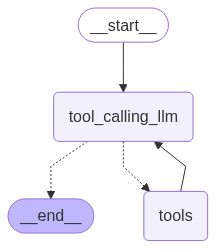

In [35]:
graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
from pprint import pprint

In [36]:
messages=graph.invoke({"messages":HumanMessage(content="What is attention is all you need and what is 2 plus 2")})
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is attention is all you need and what is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  arxiv (bec4zvh3e)
 Call ID: bec4zvh3e
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time o
================================== Ai Message ==================================

"Attenti

In [30]:
messages=graph.invoke({"messages":HumanMessage(content="What is recent news in AI")})
messages=graph.invoke({"messages":HumanMessage(content="What are best practices in AI")})
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What are best practices in AI
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (mydtkf66x)
 Call ID: mydtkf66x
  Args:
    query: best practices in AI 2023
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "The state of AI in 2023: Generative AI's breakout year | McKinsey", "url": "https://www.mckinsey.com/capabilities/quantumblack/our-insights/the-state-of-ai-in-2023-generative-ais-breakout-year", "content": "The findings offer further evidence that even high performers haven’t mastered best practices regarding AI adoption, such as machine-learning-operations (MLOps) approaches, though they are much more likely than others to do so. For example, just 35 percent of respondents at AI high performers report that where possible, their organizations assemble exis

In [31]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================

Machine learning is a subset of artificial intelligence (AI) that involves the use of algorithms and statistical models to enable machines to perform a specific task without using explicit instructions, instead relying on patterns and inference from data. In simpler terms, machine learning allows computers to learn from data and improve their performance on a task over time.

There are several types of machine learning, including:

1. **Supervised Learning**: The model is trained on labeled data, meaning the data is already tagged with the correct output. The model learns by example to make predictions or decisions.

2. **Unsupervised Learning**: The model is trained on unlabeled data and aims to find hidden patterns or intrinsic structures in the data.

3. **Reinforcement Learning**: The model learn